In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import theano

In [2]:
def unconditionalProbability(Ptrans):
   """Compute the unconditional probability for the states of a
   Markov chain."""

   m = Ptrans.shape[0]

   P = np.column_stack((Ptrans, 1. - Ptrans.sum(axis=1)))

   I = np.eye(m)
   U = np.ones((m, m))
   u = np.ones(m)

   return np.linalg.solve((I - P + U).T, u)



In [3]:
data = np.loadtxt('test_data.txt',
                 dtype=np.dtype([('state', np.uint8),
                                 ('emission', np.float)]),
                 delimiter=',',
                 skiprows=1)

data['state'] = data['state']-1
data['state']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0,

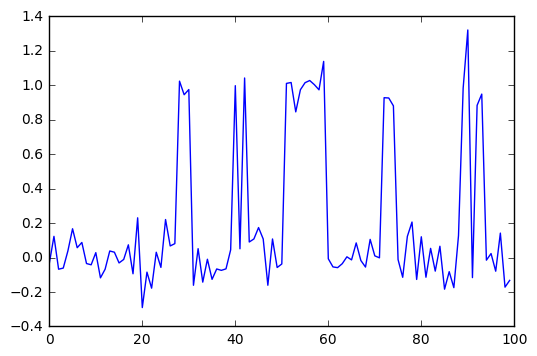

In [4]:
measurement = data['state']*1.0 + 0.1*np.random.randn(len(data['state']))
plt.plot(measurement[:100])

In [5]:
# Two state model for simplicity.
N_states = 2
N_chain = len(data)

# Transition probability stochastic
theta = np.ones(N_states) + 1.
alphaA = 2.1
betaA = 1.1
alphaS = 11.0
betaS = 1.

In [9]:
class HMMStates(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P1 : tensor
        probability to remain in state 1
    P2 : tensor
        probability to move from state 2 to state 1
    
    """

    def __init__(self, PA=None, P1=None, P2=None,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.PA = PA
        self.P1 = P1
        self.P2 = P2
        self.k = 2 # two state model
        self.mean = 0.
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        PA = self.PA
        P1 = self.P1
        P2 = self.P2
        
        # now we need to create an array with probabilities
        # so that for x=A: PA=P1, PB=(1-P1)
        # and for x=B: PA=P2, PB=(1-P2)
        # for more than two states we may use tt.choose()
#        length = x.shape[0]
        PT = tt.stack((P1,P2))
        
        P = PT[x[:-1]]
        
        x_i = x[1:]
        
        ou_like = pm.Categorical.dist(P, shape=(N_chain-1,2)).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)


In [12]:
class HMMGaussianEmmisions(pm.Continuous):
    """
    Hidden Markov Model Gaussian Emmisions
    Parameters
    ----------
    A : tensor
        prior for Gaussian emmision mu
        shape = (2,N_states)
        
    S : tensor
        prior for Gaussian emmision width
        shape = (2,N_states)
    
    states : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, A1=None, A2=None, S1=None, S2=None, states=None,
                 *args, **kwargs):
        super(HMMGaussianEmmisions, self).__init__(*args, **kwargs)
        self.A1 = A1
        self.S1 = S1
        self.A2 = A2
        self.S2 = S2
        self.states = states
        self.mean = 0.

    def logp(self, x):
        A1 = self.A1
        S1 = self.S1
        A2 = self.A2
        S2 = self.S2
        states = self.states
        
#        length = x.shape[0]
#        AT = tt.tile(A.T,(length,1,1))
#        ST = tt.tile(S.T,(length,1,1))
        
#        AS = tt.switch(states,AT.T)        
#        SS = tt.switch(states,ST.T)
        AT = tt.stack((A1,A2))
        AS = AT[states]
        
        ST = tt.stack((S1,S2))
        SS = ST[states]
        
        ou_like = pm.Normal.dist(mu=AS,sd=SS).logp(x)
        return tt.sum(ou_like)


In [13]:
theano.config.exception_verbosity = 'high'
from scipy import optimize
with pm.Model() as model:
    # 2 state model
    # P1 is probablility to stay in state 1
    # P2 is probability to move from state 2 to state 1
    P1 = pm.Dirichlet('P1', a=theta)
    P2 = pm.Dirichlet('P2', a=theta)
    
    A1 = pm.Normal('A1',mu=0, sd=1)
    A2 = pm.Normal('A2',mu=1, sd=1)
    S1 = pm.InverseGamma('S1',alpha=alphaS, beta=betaS)
    S2 = pm.InverseGamma('S2',alpha=alphaS, beta=betaS)
    
    PA = pm.Deterministic('PA',P2/(P2+1-P1))
    
    states = HMMStates('states',PA,P1,P2, shape=N_chain)
    
    emission = HMMGaussianEmmisions('emission',
                                    A1=A1,
                                    A2=A1,
                                    S1=S1,
                                    S2=S2,
                                    states=states,
                                    observed = measurement)
    
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    step1 = pm.Metropolis(vars=[P1, P2, A1, A2, S1, S2, PA, emission])
    step2 = pm.BinaryGibbsMetropolis(vars=[states])
    trace = pm.sample(10000, start=start, step=[step1, step2])

Optimization terminated successfully.
         Current function value: 626.080786
         Iterations: 3
         Function evaluations: 233


 22%|██▏       | 2167/10000 [09:38<36:50,  3.54it/s]

In [ ]:
%matplotlib inline
pm.traceplot(trace[1000:])

In [ ]:
sample_avg=np.average(trace['states'][1000:],axis=0)

In [ ]:
plt.plot(measurement[100:200])
plt.plot(1-sample_avg[100:200])